In [0]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix , accuracy_score
import cv2
from keras import backend as K
import numpy as np
from numpy import argmax
import sys
import tensorflow as tf

color = sns.color_palette()
%matplotlib inline

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [0]:
# Define path to the data directory
data_dir = Path('./drive/My Drive/X-ray_ML')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

**Prepare training data**

In [28]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,drive/My Drive/X-ray_ML/train/NORMAL/IM-0461-0...,0
1,drive/My Drive/X-ray_ML/train/NORMAL/NORMAL2-I...,0
2,drive/My Drive/X-ray_ML/train/PNEUMONIA/person...,1
3,drive/My Drive/X-ray_ML/train/PNEUMONIA/person...,1
4,drive/My Drive/X-ray_ML/train/PNEUMONIA/person...,1


**Prepare validating data**

In [29]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 1)


In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,1), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
              
           # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = [label]
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = [label]
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = [label]
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

**InceptionV3 Model**

In [0]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
def build_model_InceptionV3():
    base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(100, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [0]:
model_InceptionV3 =  build_model_InceptionV3()
model_InceptionV3.summary()

87916544/87910968 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
___________________________

In [0]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [0]:
model_InceptionV3.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [0]:
batch_size = 32
nb_epochs = 10

def prepareTraining(batch_size,nb_epochs):
  # Get a train data generator
  train_data_gen = data_gen(data=train_data, batch_size=batch_size)

  # Define the number of training steps
  nb_train_steps = train_data.shape[0]//batch_size

  print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

  return train_data_gen,nb_train_steps

In [0]:
train_data_gen,nb_train_steps = prepareTraining(batch_size,nb_epochs)

Number of training and validation steps: 163 and 16


In [0]:
train_data_gen.shape

AttributeError: ignored

In [0]:
history_InceptionV3 = model_InceptionV3.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})



Epoch 1/10
163/163 [==============================] - 939s 6s/step - loss: 0.0750 - acc: 0.9480 - val_loss: 0.2655 - val_acc: 0.8750
Epoch 2/10
163/163 [==============================] - 441s 3s/step - loss: 0.0358 - acc: 0.9795 - val_loss: 0.5218 - val_acc: 0.8125
Epoch 3/10
163/163 [==============================] - 260s 2s/step - loss: 0.0274 - acc: 0.9872 - val_loss: 0.2339 - val_acc: 0.9375
Epoch 4/10
163/163 [==============================] - 164s 1s/step - loss: 0.0174 - acc: 0.9906 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 5/10
163/163 [==============================] - 132s 813ms/step - loss: 0.0134 - acc: 0.9954 - val_loss: 0.0179 - val_acc: 1.0000
Epoch 6/10
163/163 [==============================] - 100s 611ms/step - loss: 0.0054 - acc: 0.9962 - val_loss: 0.0309 - val_acc: 1.0000
Epoch 7/10
163/163 [==============================] - 90s 551ms/step - loss: 0.0082 - acc: 0.9977 - val_loss: 0.0626 - val_acc: 0.9375
Epoch 8/10
163/163 [==============================] - 83s 5

In [0]:
def showHistory(model_history):  
  # summarize history for accuracy
  plt.figure(figsize=(12,6),)
  plt.plot(model_history.history['acc'])
  plt.plot(model_history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy',color = 'white')
  plt.xlabel('epoch',color = 'white')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,6))
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss',color = 'white')
  plt.xlabel('epoch',color = 'white')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

**Prepare testing data**

In [34]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = 0
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = 1
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels).reshape(-1,1)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 1)


In [0]:
def evaluateModel(model):
  test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
  print("Loss on test set: ", test_loss)
  print("Accuracy on test set: ", test_score)

In [0]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

def roc(model):
  # Get predictions
  preds = model.predict(test_data)

  fpr, tpr, threshold = roc_curve(test_labels,preds)
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr,tpr,'b',label='AUC = %0.2f' % roc_auc)
  plt.legend(loc= 'lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.ylabel('True positive rate')
  plt.xlabel('False positive rate')
  plt.show()

def report(model):
  # Get predictions
  preds = model.predict(test_data)
  y_pred = np.where(preds >= 0.5, 1, 0)
  target_names = ['Control', 'Pnemonia']
  print(classification_report(test_labels, y_pred, target_names=target_names))

**Result of InceptionV3**


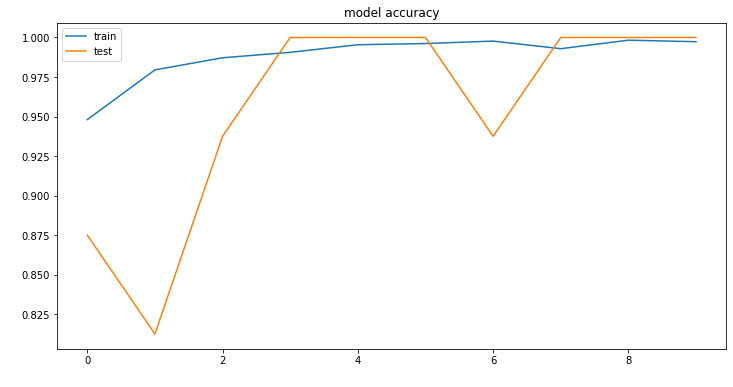

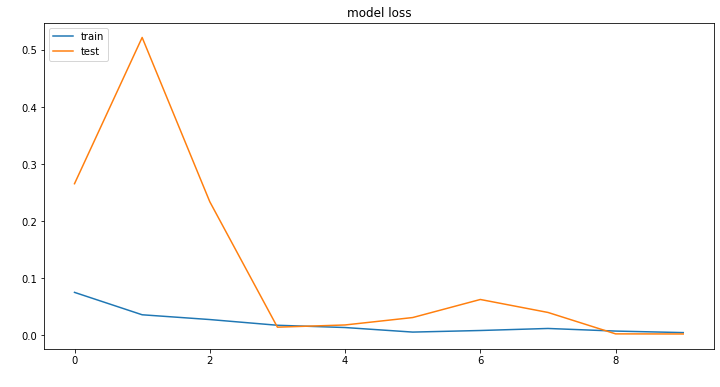

In [0]:
showHistory(history_InceptionV3)

In [0]:
evaluateModel(model_InceptionV3)

624/624 [==============================] - 2s 2ms/step
Loss on test set:  0.964456060799794
Accuracy on test set:  0.8189102564102564


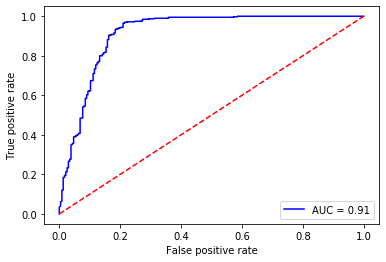

In [0]:
roc(model_InceptionV3)

In [0]:
report(model_InceptionV3)

              precision    recall  f1-score   support

     Control       0.98      0.53      0.69       234
    Pnemonia       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



In [0]:
model_InceptionV3.save('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_InceptionV3_v1.h5')
model_InceptionV3.save_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_InceptionV3_v1.h5')

**Custom Model**

In [0]:
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
def build_model_custom(): 
  inputs = Input(shape=(224,224,3))

  # First conv block
  x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
  x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  # Second conv block
  x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  # Third conv block
  x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  # Fourth conv block
  x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Dropout(rate=0.2)(x)

  # Fifth conv block
  x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Dropout(rate=0.2)(x)

  # FC layer
  x = Flatten()(x)
  x = Dense(units=512, activation='relu')(x)
  x = Dropout(rate=0.7)(x)
  x = Dense(units=128, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(units=64, activation='relu')(x)
  x = Dropout(rate=0.3)(x)

  # Output layer
  output = Dense(units=1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=output)
  return model

In [38]:
model_custom = build_model_custom()
model_custom.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 112, 112, 32)      1344      
_________________________________________________________________
separable_conv2d_10 (Separab (None, 112, 112, 32)      1344      
_________________________________________________________________
batch_normalization_5 (Batch (None, 112, 112, 32)      128 

In [39]:
epochs = 10
batch_size = 64
train_data_gen,nb_train_steps = prepareTraining(batch_size,nb_epochs)

model_custom.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Number of training and validation steps: 81 and 16


In [40]:
history_custom = model_custom.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt])

Epoch 1/10
 1/81 [..............................] - ETA: 30:16 - loss: 0.6934 - acc: 0.3906

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


KeyboardInterrupt: ignored

In [0]:
showHistory(history_custom)

In [0]:
evaluateModel(model_custom)

In [0]:
roc(model_custom)

In [0]:
report(model_custom)

In [0]:
model_custom.save('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_custom_v1.h5')
model_custom.save_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_custom_v1.h5')

**Xception Model**

In [0]:
from keras.applications.xception import Xception
def build_model_Xception():
  base_model = Xception(weights='imagenet', include_top=False,input_shape=(224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(100, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)
    
  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [0]:
model_Xception = build_model_Xception()
model_Xception.summary()

83689472/83683744 [==============================] - 7s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________

In [0]:
epochs = 10
batch_size = 32
train_data_gen,nb_train_steps = prepareTraining(batch_size,nb_epochs)

model_Xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Number of training and validation steps: 163 and 16


In [0]:
history_Xception = model_Xception.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt])

Epoch 1/10
163/163 [==============================] - 109s 669ms/step - loss: 0.1335 - acc: 0.9576 - val_loss: 0.5775 - val_acc: 0.9375
Epoch 2/10
163/163 [==============================] - 97s 592ms/step - loss: 0.0746 - acc: 0.9787 - val_loss: 1.0933 - val_acc: 0.8750
Epoch 3/10
163/163 [==============================] - 99s 608ms/step - loss: 0.0383 - acc: 0.9837 - val_loss: 0.0880 - val_acc: 0.9375
Epoch 4/10
163/163 [==============================] - 96s 589ms/step - loss: 0.0223 - acc: 0.9933 - val_loss: 0.8265 - val_acc: 0.7500
Epoch 5/10
163/163 [==============================] - 95s 585ms/step - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0269 - val_acc: 1.0000
Epoch 6/10
163/163 [==============================] - 96s 591ms/step - loss: 0.0453 - acc: 0.9850 - val_loss: 0.3486 - val_acc: 0.8750
Epoch 7/10
163/163 [==============================] - 98s 598ms/step - loss: 0.0194 - acc: 0.9921 - val_loss: 0.2290 - val_acc: 0.9375
Epoch 8/10
163/163 [==============================] - 

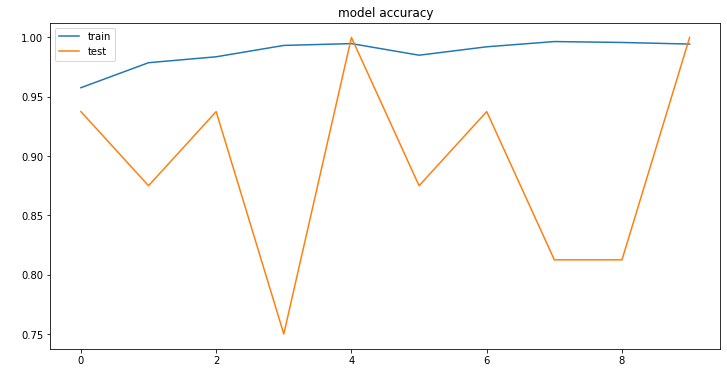

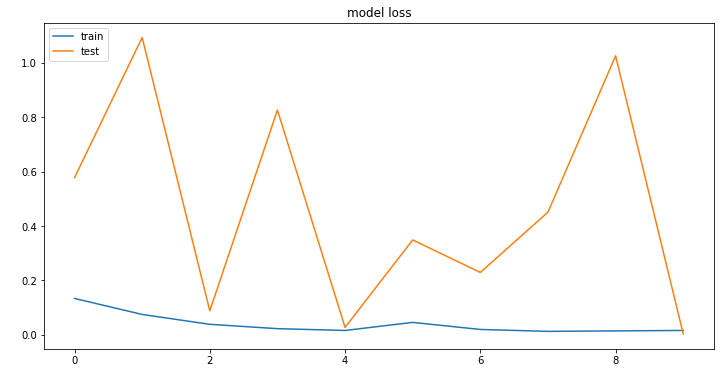

In [0]:
showHistory(history_Xception)

In [0]:
evaluateModel(model_Xception)

624/624 [==============================] - 2s 4ms/step
Loss on test set:  0.755689112371204
Accuracy on test set:  0.8782051282051282


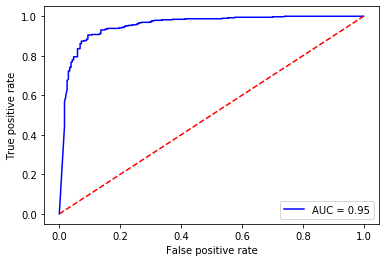

In [0]:
roc(model_Xception)

In [0]:
report(model_Xception)

              precision    recall  f1-score   support

     Control       0.93      0.73      0.82       234
    Pnemonia       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



In [0]:
model_Xception.save('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_Xception_v1.h5')
model_Xception.save_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_Xception_v1.h5')

In [0]:
from keras.applications.resnet import ResNet50
def build_model_ResNet50():
  base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(100, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)
    
  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [0]:
model_ResNet50 = build_model_ResNet50()
model_ResNet50.summary()













94773248/94765736 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________

In [0]:
epochs = 10
batch_size = 32
train_data_gen,nb_train_steps = prepareTraining(batch_size,nb_epochs)

model_ResNet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history_ResNet50 = model_ResNet50.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt])



Epoch 1/10
 5/81 [>.............................] - ETA: 33:40 - loss: 0.4907 - acc: 0.8375

KeyboardInterrupt: ignored

In [0]:
showHistory(history_ResNet50)

In [0]:
evaluateModel(model_ResNet50)

In [0]:
roc(model_ResNet50)

In [0]:
report(model_ResNet50)

In [0]:
model_ResNet50.save('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_ResNet50_v1.h5')
model_ResNet50.save_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_ResNet50_v1.h5')

**DenseNet121 Model**

In [0]:
from keras.applications.densenet import DenseNet121
def build_model_DenseNet121():
  base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(100, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)
    
  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [0]:
model_ResNet50 = build_model_ResNet50()
model_ResNet50.summary()

In [0]:
epochs = 10
batch_size = 32
train_data_gen,nb_train_steps = prepareTraining(batch_size,nb_epochs)

model_DenseNet121.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
history_DenseNet121 = model_DenseNet121.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt])

In [0]:
showHistory(history_DenseNet121)

In [0]:
evaluateModel(model_DenseNet121)

In [0]:
roc(model_DenseNet121)

In [0]:
report(model_DenseNet121)

In [0]:
model_DenseNet121.save('./drive/My Drive/X-ray_ML/model_stack_ensemble/model_DenseNet121_v1.h5')
model_DenseNet121.save_weights('./drive/My Drive/X-ray_ML/model_stack_ensemble/weight_DenseNet121_v1.h5')